In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

df = pd.read_csv("/content/data.csv")


X = df.drop(columns=['Stress Level'])
y = df['Stress Level']


Prepocessing for converting categorical to encode

In [ ]:
categorical_features = ['Stress Causes', 'Behavioral Effects', 'Psychological Effects',
                        'Cognitive Effects', 'Social Effects', 'Stress Relievers',
                        'Pressing Academic Stressors']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


numeric_features = ['Daily Stress (1-10)', 'Stress Handling (1-10)']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

Models are trained and their scores are displayed


Random Forest - Cross-Validation MSE Scores: [0.16613057 0.16998886 0.60323383 0.30325733 0.04890467]
Random Forest - Mean Cross-Validation MSE: 0.2583030523809522
Random Forest - Test Set MSE: 0.37228349999999866
Random Forest - Test Set MAE: 0.5149999999999978

Gradient Boosting - Cross-Validation MSE Scores: [0.17938198 0.25162378 0.54594983 0.21129768 0.10789608]
Gradient Boosting - Mean Cross-Validation MSE: 0.25922987006966525
Gradient Boosting - Test Set MSE: 0.28847701404626414
Gradient Boosting - Test Set MAE: 0.4636039359960658

SVR - Cross-Validation MSE Scores: [0.60562892 0.27378299 0.7415158  1.08720217 1.03539635]
SVR - Mean Cross-Validation MSE: 0.748705246918202
SVR - Test Set MSE: 0.45918926056430487
SVR - Test Set MAE: 0.5405627484200235

Decision Tree - Cross-Validation MSE Scores: [0.31571429 0.75       1.68333333 0.32666667 0.515     ]
Decision Tree - Mean Cross-Validation MSE: 0.7181428571428572
Decision Tree - Test Set MSE: 0.24500000000000008
Decision Tree - T

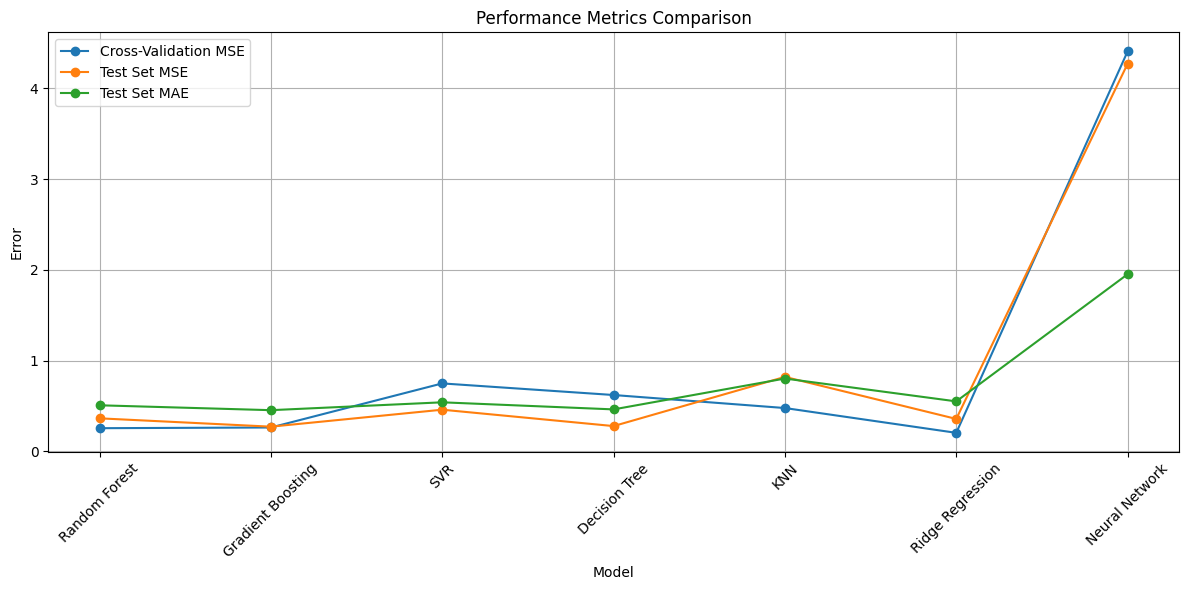

In [ ]:
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'Ridge Regression': Ridge(),
    'Neural Network': MLPRegressor(max_iter=1000)
}


for name, model in models.items():

    regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', model)])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    regressor.fit(X_train, y_train)


    joblib.dump(regressor, f'{name.lower().replace(" ", "_")}_model.pkl')

    cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores = -cv_scores


    print(f"\n{name} - Cross-Validation MSE Scores:", cv_scores)
    print(f"{name} - Mean Cross-Validation MSE:", cv_scores.mean())


    y_pred = regressor.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - Test Set MSE:", mse)


    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} - Test Set MAE:", mae)


    if name in ['Random Forest', 'Gradient Boosting']:
        feature_importance = regressor.named_steps['regressor'].feature_importances_


        feature_names = (regressor.named_steps['preprocessor']
                                   .transformers_[0][1]
                                   .named_steps['onehot']
                                   .get_feature_names_out(input_features=categorical_features))


        numeric_feature_names = numeric_features
        all_feature_names = list(feature_names) + numeric_feature_names


plt.figure(figsize=(12, 6))
plt.plot(results_df['Model'], results_df['Cross-Validation MSE'], marker='o', label='Cross-Validation MSE')
plt.plot(results_df['Model'], results_df['Test Set MSE'], marker='o', label='Test Set MSE')
plt.plot(results_df['Model'], results_df['Test Set MAE'], marker='o', label='Test Set MAE')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Code to test on custom input

In [ ]:
import pandas as pd
import joblib


model = joblib.load('/content/random_forest_model.pkl')


def preprocess_input(data):

    df = pd.DataFrame(data, index=[0])


    categorical_features = ['Stress Causes', 'Behavioral Effects', 'Psychological Effects',
                            'Cognitive Effects', 'Social Effects', 'Stress Relievers',
                            'Pressing Academic Stressors']


    numeric_features = ['Daily Stress (1-10)', 'Stress Handling (1-10)']


    cat_df = df[categorical_features].fillna('missing')


    num_df = df[numeric_features].fillna(df[numeric_features].median())


    processed_data = pd.concat([cat_df, num_df], axis=1)

    return processed_data


def predict_stress_level(input_data):

    processed_data = preprocess_input(input_data)


    prediction = model.predict(processed_data)

    return prediction


custom_input = {
    'Daily Stress (1-10)': 4,
    'Stress Causes': 'Work-related issues, Financial issues, Health issues',
    'Behavioral Effects': 'Irritability, Change in sleep patterns',
    'Psychological Effects': 'Anxiety, Depression',
    'Cognitive Effects': 'Memory problems, Difficulty concentrating',
    'Social Effects': 'Withdrawing, Difficulty listening',
    'Stress Relievers': 'Talking with someone, Music',
    'Stress Handling (1-10)': 10,
    'Pressing Academic Stressors': 'Work-Life balance, Career growth'
}


prediction = predict_stress_level(custom_input)
print("Predicted Stress Level:", prediction[0])


Predicted Stress Level: 4.129000000000001
